In [1]:
import numpy as np
import os
import pandas
import datetime
import matplotlib.pyplot as plt
import world_bank_data as wb
import seaborn as sns; sns.set_theme()
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
def plot_kmeans_clusters(x_column, y_column, df, clusters_data):
    colors = cm.nipy_spectral(clusters_data.labels_.astype(float) / len(clusters_data.cluster_centers_))

    x = df[x_column]
    y = df[y_column]

    plt.scatter(x, y, marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusters_data.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(centers[:, df.columns.get_loc(x_column)],
                centers[:, df.columns.get_loc(y_column)],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        plt.scatter(c[df.columns.get_loc(x_column)],
                    c[df.columns.get_loc(y_column)],
                    marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    
    plt.show()

# Prepare data

In [4]:
df1 = pandas.read_excel("temp.xlsx")
df1

,ISO_3DIGIT,Oct_temp,Nov_Temp,Avg_Temp,Oct_precip,Nov_precip,Avg_precip
0,AFG,12.992646,7.004094,9.998370,9.355273,15.409127,12.382200
1,AGO,23.181599,22.786151,22.983875,69.766698,144.510161,107.138430
2,ALB,12.265775,7.575808,9.920792,105.261417,138.264167,121.762792
3,ARE,28.343218,24.061783,26.202500,0.428552,1.740576,1.084564
4,ARG,14.674651,17.544032,16.109342,47.715487,55.566664,51.641076
...,...,...,...,...,...,...,...
173,VUT,23.263500,24.276500,23.770000,174.350006,193.770004,184.060005
174,YEM,23.016221,20.303857,21.660039,4.632454,8.950662,6.791558
175,ZAF,18.310131,20.480351,19.395241,42.568024,55.077712,48.822868
176,ZMB,24.669040,24.192320,24.430680,32.033640,111.564148,71.798894


In [5]:
df_new = df1.copy()
df_new = df_new.drop(columns=[
    "ISO_3DIGIT",
    "Oct_temp",
    "Nov_Temp",
    "Oct_precip",
    "Nov_precip",
])
df_new

,Avg_Temp,Avg_precip
0,9.998370,12.382200
1,22.983875,107.138430
2,9.920792,121.762792
3,26.202500,1.084564
4,16.109342,51.641076
...,...,...
173,23.770000,184.060005
174,21.660039,6.791558
175,19.395241,48.822868
176,24.430680,71.798894


# Statistics

In [6]:
df_ready_data_numeric_sum = pandas.DataFrame(df1.isnull().sum(), columns = ["missing"])
df_ready_data_numeric_max = pandas.DataFrame(df1.max(), columns = ["max"])
df_ready_data_numeric_min = pandas.DataFrame(df1.min(), columns = ["min"])
df_ready_data_numeric_mean = pandas.DataFrame(df1.mean(), columns = ["mean"])
df_ready_data_numeric_median = pandas.DataFrame(df1.median(), columns = ["median"])
df_ready_data_numeric_std = pandas.DataFrame(df1.std(), columns = ["std"])

frames = [df_ready_data_numeric_sum,
         df_ready_data_numeric_max,
         df_ready_data_numeric_min,
         df_ready_data_numeric_mean,
         df_ready_data_numeric_median,
         df_ready_data_numeric_std]

df_statistics = pandas.concat(frames, axis=1)
df_statistics

,missing,max,min,mean,median,std
ISO_3DIGIT,0,ZWE,AFG,NaN,NaN,NaN
Oct_temp,0,29.5538,-8.35951,18.703987,22.493785,8.431630
Nov_Temp,0,27.4734,-17.6378,15.992370,21.282322,10.610441
Avg_Temp,0,28.0895,-11.4861,17.348178,22.100146,9.461004
Oct_precip,0,460.445,0.22778,100.511443,69.781847,93.103367
Nov_precip,0,365.83,0.0177419,88.242080,68.623583,79.044161
Avg_precip,0,401.41,0.884378,94.376761,74.111882,82.515213


# Clustering

### 3 clusters

In [7]:
clustering = AgglomerativeClustering(n_clusters=5).fit(df_new)
clustering.labels_

array([4, 0, 0, 4, 2, 2, 2, 0, 2, 0, 0, 2, 4, 0, 2, 0, 0, 2, 1, 0, 0, 3,
       2, 2, 0, 2, 0, 2, 2, 0, 0, 1, 1, 1, 0, 3, 0, 2, 2, 2, 4, 0, 0, 4,
       0, 4, 4, 4, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0, 0, 0, 3, 2, 0, 3, 0, 1,
       0, 0, 1, 0, 1, 2, 1, 2, 0, 4, 4, 0, 4, 0, 1, 4, 0, 2, 0, 2, 1, 2,
       0, 4, 0, 2, 1, 4, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 4, 0, 0, 4, 2, 4,
       0, 2, 3, 4, 0, 4, 2, 1, 0, 0, 2, 0, 4, 4, 3, 0, 1, 1, 2, 1, 2, 0,
       0, 4, 0, 2, 2, 0, 4, 4, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 4,
       4, 0, 0, 2, 4, 0, 1, 2, 2, 0, 0, 2, 0, 2, 4, 1, 0, 1, 1, 1, 4, 2,
       0, 2], dtype=int64)

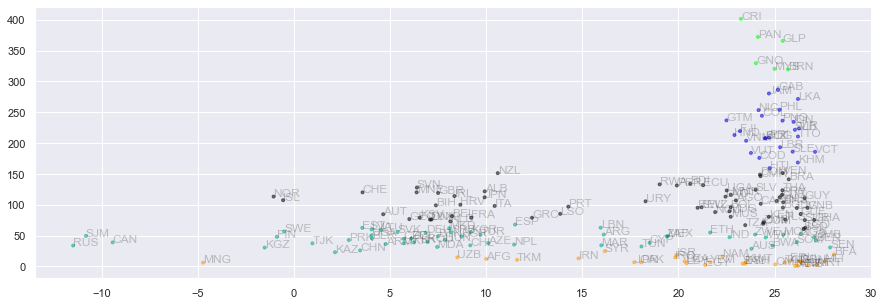

In [8]:
#%matplotlib notebook
colors = cm.nipy_spectral(clustering.labels_.astype(float) / clustering.n_clusters_)
plt.scatter(df_new["Avg_Temp"], df_new["Avg_precip"], alpha=0.5, c=colors, marker='.')
for i, txt in enumerate(df1.ISO_3DIGIT):
    plt.annotate(txt, (df_new["Avg_Temp"][i], df_new["Avg_precip"][i]), alpha=0.25)

## dendrogram

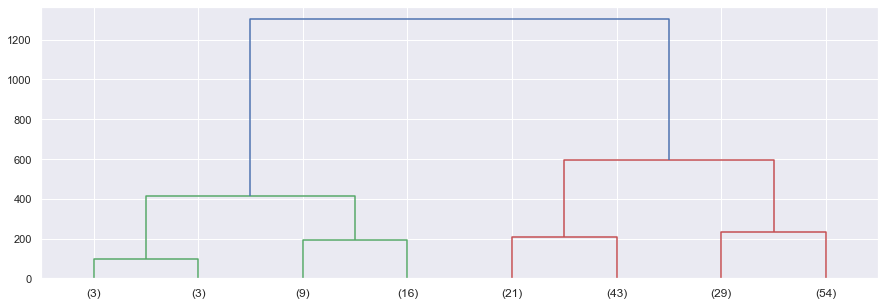

In [9]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df_new)
plot_dendrogram(clustering, truncate_mode='level', p=2)

# Clasification

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [11]:
df_new_norm = pandas.DataFrame(MinMaxScaler().fit_transform(df_new))
df_new_norm.columns = df_new.columns
df_new_norm

,Avg_Temp,Avg_precip
0,0.542871,0.028707
1,0.870990,0.265287
2,0.540911,0.301799
3,0.952318,0.000500
4,0.697283,0.126725
...,...,...
173,0.890854,0.457338
174,0.837539,0.014749
175,0.780312,0.119689
176,0.907548,0.177054


In [12]:
train, test = train_test_split(df_new_norm, test_size=0.5, random_state=0)
train

,Avg_Temp,Avg_precip
69,0.508919,0.247605
49,0.379990,0.154142
48,0.580769,0.167267
85,0.251681,0.074186
13,0.932862,0.236150
...,...,...
103,0.494283,0.152468
67,0.961408,0.274046
117,0.900808,0.630722
47,0.883336,0.009714


In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=10,
    max_iter=300,
    random_state=43)

clusters_data = kmeans.fit(df_new_norm)

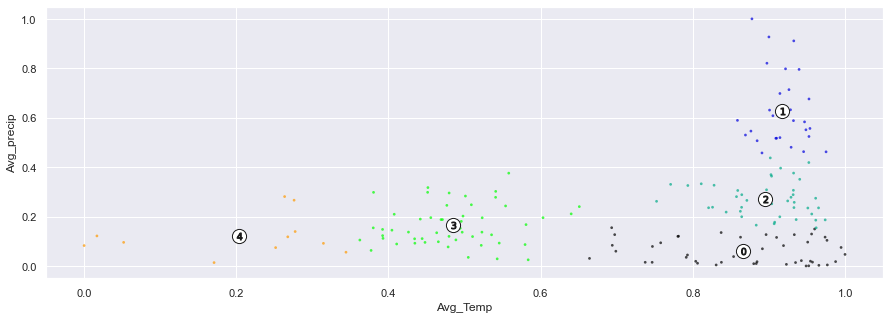

In [14]:
plot_kmeans_clusters("Avg_Temp", "Avg_precip", df_new_norm, clusters_data)

In [15]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train, clusters_data.labels_[train.index])

KNeighborsClassifier(n_neighbors=3)

In [16]:
neigh.predict(test)

array([3, 4, 1, 1, 0, 3, 3, 1, 3, 2, 4, 3, 3, 3, 3, 1, 1, 1, 0, 4, 2, 0,
       0, 0, 1, 0, 1, 1, 1, 2, 4, 3, 1, 0, 3, 2, 0, 1, 1, 0, 2, 2, 0, 2,
       0, 2, 3, 3, 2, 3, 3, 0, 0, 3, 3, 0, 0, 0, 3, 3, 2, 3, 3, 2, 3, 3,
       2, 2, 3, 2, 3, 3, 0, 3, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 3, 0,
       1])

In [17]:
neigh.score(test, clusters_data.labels_[test.index])

0.9662921348314607

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train, clusters_data.labels_[train.index])

[Text(372.0, 237.82500000000002, 'X[0] <= 0.622\ngini = 0.773\nsamples = 89\nvalue = [22, 14, 21, 25, 7]'),
 Text(186.0, 169.875, 'X[0] <= 0.338\ngini = 0.342\nsamples = 32\nvalue = [0, 0, 0, 25, 7]'),
 Text(93.0, 101.92500000000001, 'gini = 0.0\nsamples = 7\nvalue = [0, 0, 0, 0, 7]'),
 Text(279.0, 101.92500000000001, 'gini = 0.0\nsamples = 25\nvalue = [0, 0, 0, 25, 0]'),
 Text(558.0, 169.875, 'X[1] <= 0.163\ngini = 0.655\nsamples = 57\nvalue = [22, 14, 21, 0, 0]'),
 Text(465.0, 101.92500000000001, 'gini = 0.0\nsamples = 22\nvalue = [22, 0, 0, 0, 0]'),
 Text(651.0, 101.92500000000001, 'X[1] <= 0.447\ngini = 0.48\nsamples = 35\nvalue = [0, 14, 21, 0, 0]'),
 Text(558.0, 33.974999999999994, 'gini = 0.0\nsamples = 21\nvalue = [0, 0, 21, 0, 0]'),
 Text(744.0, 33.974999999999994, 'gini = 0.0\nsamples = 14\nvalue = [0, 14, 0, 0, 0]')]

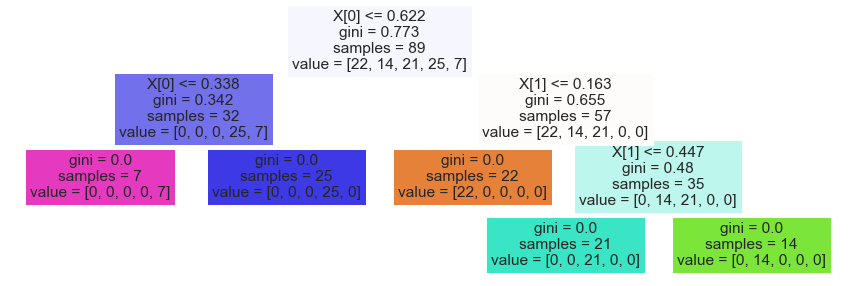

In [19]:
tree.plot_tree(clf, filled=True)